In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import random

# Ising model

In [2]:
# Generate Hamiltonian
def ising_hamiltonian(L, J, h):
        pauli_x = np.array([[0,1],[1,0]])
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)

        sx_list = []
        sz_list = []
        for i_site in range(L):
                z_ops = [id] * L
                x_ops = [id] * L
                z_ops[i_site] = pauli_z
                x_ops[i_site] = pauli_x
                ZZ = z_ops[0]
                X =  x_ops[0]
                for j in range(1, L):
                        ZZ = np.kron(ZZ, z_ops[j])
                        X = np.kron(X, x_ops[j])
                sz_list.append(ZZ)
                sx_list.append(X)
        H_zz = np.zeros((2**L, 2**L))
        H_x = np.zeros((2**L, 2**L))

        for i in range(L-1):
                H_zz += np.matmul(sz_list[i], sz_list[(i + 1)])
                H_x += sx_list[i]

        H_x += sx_list[L-1]

        return np.matrix(-J * H_zz - h * H_x)

# Magnetization operator
def M(L):
        pauli_z = np.array([[1,0],[0,-1]])
        id = np.eye(2)

        sz_list = []
        for i_site in range(L):
                z_ops = [id] * L
                z_ops[i_site] = pauli_z
                Z = z_ops[0]
                for j in range(1, L):
                        Z = np.kron(Z, z_ops[j])
                sz_list.append(Z)
        H_z = np.zeros((2**L, 2**L))

        for i in range(L):
                H_z += sz_list[i]
        return np.matrix(H_z)/L

In [3]:
L = 12

h_list = np.arange(100)/300

M_op = M(L)
ground_energies = []
first_excited = []
second_excited = []
third_excited = []
for h in h_list:
    energy, state = eigh(ising_hamiltonian(L, 1, h), eigvals_only = False)
    energy.sort()
    ground_energies.append(energy[0])
    first_excited.append(energy[1])
    

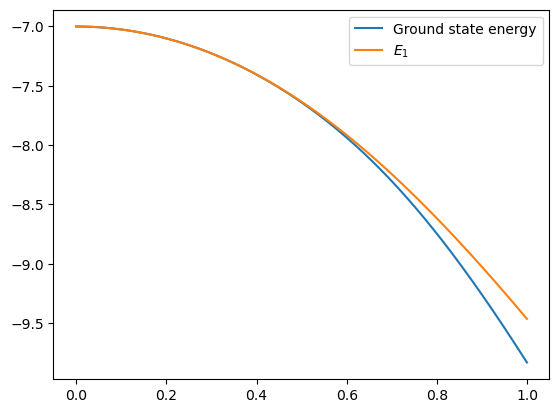

In [51]:
plt.plot(h_list, ground_energies, label = 'Ground state energy')
plt.plot(h_list, first_excited, label = r'$E_1$')

plt.legend()

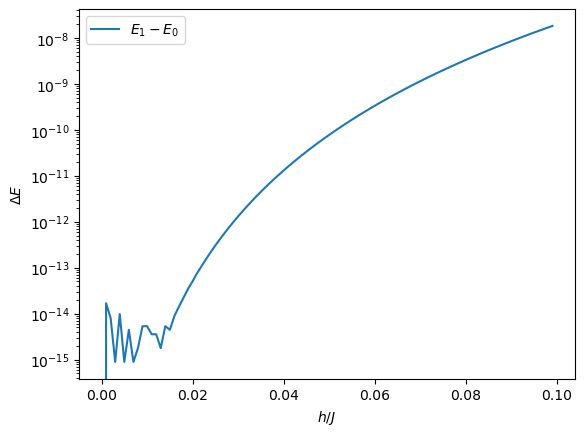

In [52]:
gap = np.array(first_excited) - np.array(ground_energies)
plt.plot(h_list[:100], gap[:100], label = r'$E_1 - E_0$')
plt.xlabel(r'$h/J$')
plt.ylabel(r'$\Delta E$')
plt.yscale('log')
plt.legend()


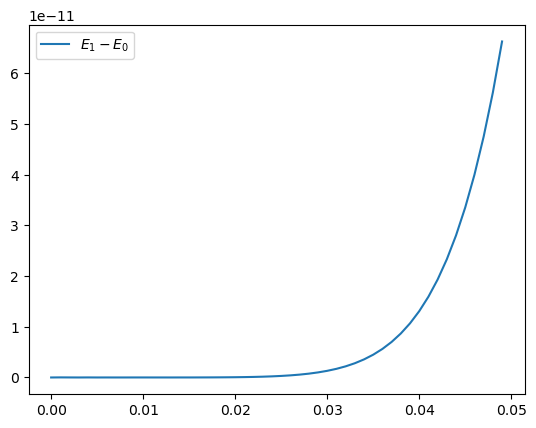

In [35]:
gap = np.array(first_excited) - np.array(ground_energies)
plt.plot(h_list[:50], gap[:50], label = r'$E_1 - E_0$')
plt.legend()

# QAOA for ground state

In [55]:
import pennylane as qml
from pennylane import qaoa
from networkx import Graph

In [56]:
wires = range(3)
graph = Graph([(0, 1), (1, 2), (2, 0)])
cost_h, mixer_h = qaoa.maxcut(graph)

In [58]:
mixer_h

  (1) [X0]
+ (1) [X1]
+ (1) [X2]


In [ ]:
>>> coeffs = [0.2, -0.543]
>>> obs = [qml.PauliX(0) @ qml.PauliZ(1), qml.PauliZ(0) @ qml.Hadamard(2)]
>>> H = qml.Hamiltonian(coeffs, obs)

In [214]:
L = 8
h=1
wires = range(L)

# Ising Hamiltonian
coeffs = [-1]*(L-1) + [-1*h]*L
obs = []
for i in range(L-1):
    obs.append(qml.PauliZ(i) @ qml.PauliZ(i+1))
for i in range(L):
    obs.append(qml.PauliX(i))

H_ising = qml.Hamiltonian(coeffs, obs, grouping_type='commuting')

## Mixer Hamiltonian
obs_mix = []
for i in range(L):
    obs_mix.append(qml.PauliX(i))
H_mixer = qml.Hamiltonian(-1 * np.ones(L), obs_mix, grouping_type='commuting')

In [215]:
def cost_l(param):
    for i in range(L-1):
        qml.IsingZZ(param, wires = [wires[i], wires[i+1]])
    for i in range(L):
        qml.RX(param, wires[i])

In [223]:
def qaoa_layer(gamma, alpha):
    cost_l(gamma)
    qaoa.mixer_layer(alpha, H_mixer)
    
def circuit(params, num_layers = 10):

    for w in wires:
        qml.Hadamard(wires=w)

    qml.layer(qaoa_layer, num_layers, params[0], params[1])

In [224]:
dev = qml.device('default.qubit', wires=len(wires))
@qml.qnode(dev)
def cost_fn(params, num_layers=10):
    circuit(params, num_layers)
    return qml.expval(H_ising)

In [247]:
L = 8
num_layers = 10
wires = range(L)
steps = 500


ground_energies_qaoa = []
qaoa_coeffs = []

h_list = np.arange(10)/250

for h in h_list:

    # Ising Hamiltonian
    coeffs = [-1]*(L-1) + [-1*h]*L
    obs = []
    for i in range(L-1):
        obs.append(qml.PauliZ(i) @ qml.PauliZ(i+1))
    for i in range(L):
        obs.append(qml.PauliX(i))

    H_ising = qml.Hamiltonian(coeffs, obs, grouping_type='commuting')

    ## Mixer Hamiltonian
    obs_mix = []
    for i in range(L):
        obs_mix.append(qml.PauliX(i))
    H_mixer = qml.Hamiltonian(-1 * np.ones(L), obs_mix, grouping_type='commuting')


    init_params = np.random.randn(2, num_layers, requires_grad = True)
    params = init_params


    opt = qml.AdagradOptimizer(stepsize=0.5)

    for i in range(steps):
        params = opt.step(lambda l: cost_fn(l, num_layers), params)
        if (i + 1) % 50 == 0:
            print("Objective after step {:5d}: {: .7f}".format(i + 1, cost_fn(params, num_layers)))
        
    ground_energies_qaoa.append(cost_fn(params, num_layers))
    qaoa_coeffs.append(params)

Objective after step    50: -3.8528208
Objective after step   100: -4.2764130
Objective after step   150: -5.5428736
Objective after step   200: -5.6712949
Objective after step   250: -5.7369245
Objective after step   300: -5.7731821
Objective after step   350: -5.8097238
Objective after step   400: -5.8264011
Objective after step   450: -5.8425196
Objective after step   500: -5.8595754
Objective after step    50:  0.4267054
Objective after step   100: -5.1851550
Objective after step   150: -5.6463943
Objective after step   200: -5.6826972
Objective after step   250: -5.8753175
Objective after step   300: -5.9394308
Objective after step   350: -5.9654801
Objective after step   400: -5.9831238
Objective after step   450: -5.9986332
Objective after step   500: -6.0173745
Objective after step    50: -4.0323114
Objective after step   100: -5.7876645
Objective after step   150: -6.1644555
Objective after step   200: -6.2432259
Objective after step   250: -6.3154500
Objective after step   30

In [248]:
# np.savez("qaoa_ground_state.npz", h_list = h_list, ground_energies_qaoa = ground_energies_qaoa, qaoa_coeffs = qaoa_coeffs)

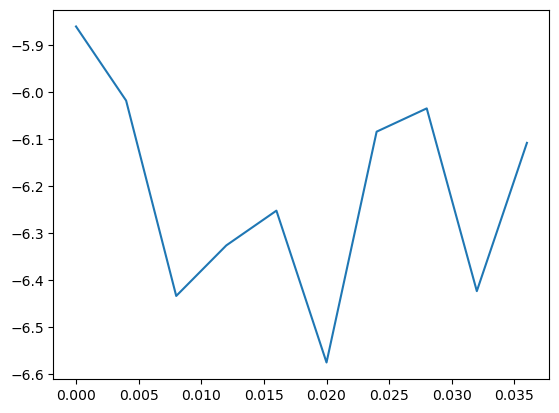

In [249]:
plt.plot(h_list, ground_energies_qaoa)